In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
import jax.numpy as jnp
import jax
import jax.tree_util as jtu
import genjax
from genjax import gen, Target, smc
from genjax import ChoiceMapBuilder as C
from config import *
from IPython.display import HTML
genjax.pretty()

from maskcombinator_model import multifirefly_model
from utils import *

from constraints import *

In [2]:
def scatter_animation(observed_xs, observed_ys, gt_xs=None, gt_ys=None):
    """
    Basic scatter plot animation with moving points
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, SCENE_SIZE)
    ax.set_ylim(SCENE_SIZE, 0)
    ax.set_title('Scatter Plot Animation')
    ax.set_facecolor("black")
    
    # Initialize scatter plot
    gt_scatter = ax.scatter([], [], edgecolors='g', facecolors=None, s=200, alpha=0.25, animated=True)
    obs_scatter = ax.scatter([], [], c='red', s=200, animated=True)

    # Animation update function
    def update(frame):
        if gt_xs is not None:
            xs = [x for x in gt_xs[frame, :] if x > 0]
            ys = [y for y in gt_ys[frame, :] if y > 0]
            gt_scatter.set_offsets(np.column_stack([xs, ys]))
            
        xs = [x for x in observed_xs[frame, :] if x > 0]
        ys = [y for y in observed_ys[frame, :] if y > 0]
        # Update scatter plot data
        obs_scatter.set_offsets(np.column_stack([xs, ys]))

        return obs_scatter, gt_scatter
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(observed_xs),  # Number of animation frames
        interval=100,  # Milliseconds between frames
        blit=True
    )
    
    return anim

# Testing a different observation model

Make sure that the observation model is `get_observed_blinks` and not the pixel based model before running this notebook.

In [3]:
importance_jit = jax.jit(multifirefly_model.importance)

In [4]:
key = jax.random.PRNGKey(1235)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 3)

constraint = C["n_fireflies"].set(jnp.int32(2))
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS # Number of time steps to simulate
tr, gt_w = importance_jit(subkey, constraint, (max_fireflies, time_mask,))
print(gt_w)
gt_chm = tr.get_sample()
gt_chm

-0.6931472


Static({
  'init': {
    'blink_rate': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈0.096 ±0.013 [≥0.083, ≤0.11] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vx': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.058 ±0.24 [≥-0.3, ≤0.18] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vy': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.37 ±0.27 [≥-0.64, ≤-0.093] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'x': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.3e+01 ±3.0 [≥1e+01, ≤1.6e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'y': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.2e+01 ±0.69 [≥1.1e+01, ≤1.2e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
  },
  'steps': {
    'dynamics': {'blinking': Choice(v=Mask(value=<jax.Array bool(30, 2) true:5 false:55>, flag=<jax.Array bool(30, 2) true:60>)), 'vx': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.028 ±1.3 [≥-1.9, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'vy': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.023 ±1.3 [≥-2.0, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'x': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.4e+01 ±8.5 [≥0.24, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'y': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.3e+01 ±8.4 [≥0.14, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>))},
    'observations': {'observed_xs': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.22 ±3.2 [≥-1.2, ≤1.5e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>)), 'observed_ys': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.24 ±3.0 [≥-1.3, ≤1.4e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>))},
  },
  'n_fireflies': Choice(v=<jax.Array(2, dtype=int32)>),
})

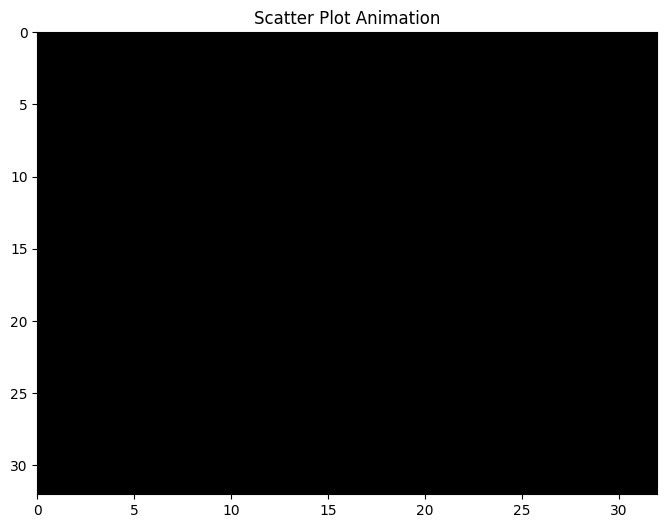

In [5]:
observed_xs, observed_ys = get_observations(gt_chm)
gt_xs, gt_ys = get_gt_locations(gt_chm)

anim = scatter_animation(observed_xs, observed_ys)
HTML(anim.to_jshtml())

In [6]:
def set_observations(observed_xs, observed_ys, max_fireflies):
    """
    Creates a choicemap encoding observed locations of fireflies at specific times

    Args:
        observed_xs, observed_ys: jnp.array: (n, t) array of observed x and y locations of fireflies
        max_fireflies: int: the maximum number of fireflies in a scene
        steps: int: the maximum number of steps in a scene
    """

    steps, n = observed_xs.shape
    chm = C.n()
    vals_x = jnp.zeros((steps, max_fireflies), jnp.float32)
    vals_y = jnp.zeros((steps, max_fireflies), jnp.float32)
    blinks = jnp.zeros((steps, max_fireflies), jnp.bool)

    # fill in addresses
    chm_dict = {}
    for t in range(steps):
        observed_xs_t = observed_xs[t]
        observed_ys_t = observed_ys[t]
        # Shuffle the indices to avoid biasing the order of the fireflies
        # indices = jax.random.permutation(jax.random.PRNGKey(t), jnp.arange(n))
        # observed_xs_t = observed_xs_t[indices]
        # observed_ys_t = observed_ys_t[indices]
        for i in range(n):
            if observed_xs_t[i] > 0:
                obs_x = observed_xs_t[i]
                obs_y = observed_ys_t[i]
                
                vals_y = vals_x.at[t, i].set(obs_x)
                vals_x = vals_y.at[t, i].set(obs_y)
                blinks = blinks.at[t, i].set(jnp.bool(True))        
                chm = chm | C["steps", t, "dynamics", i, "x"].set(obs_x)
                chm = chm | C["steps", t, "dynamics", i, "y"].set(obs_y)

    chm = chm | jax.vmap(lambda t: C["steps", t, "observations", :, "observed_xs"].set(vals_x[t]))(jnp.arange(steps))
    chm = chm | jax.vmap(lambda t: C["steps", t, "observations", :, "observed_ys"].set(vals_y[t]))(jnp.arange(steps))
    chm = chm | jax.vmap(lambda t: C["steps", t, "dynamics", "blinking", :].set(blinks[t]))(jnp.arange(steps))
    return chm

In [7]:
observed_xs, observed_ys = get_observations(gt_chm)
observations = set_observations(observed_xs, observed_ys, max_fireflies[-1])
observations

Static({
  'steps': Or(
    c1=Or(
      c1=Or(
        c1=Or(c1=Or(c1=Or(c1=Or(c1=Or(c1=Or(c1=Or(c1=Or(c1=Or(c1=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array(12.417742, dtype=float32)>)}), addr=0)}), addr=8), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array(10.70274, dtype=float32)>)}), addr=0)}), addr=8)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array(13.929169, dtype=float32)>)}), addr=0)}), addr=9)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array(12.439908, dtype=float32)>)}), addr=0)}), addr=9)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array(15.050421, dtype=float32)>)}), addr=0)}), addr=10)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array(14.236877, dtype=float32)>)}), addr=0)}), addr=10)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array(1.1989639, dtype=float32)>)}), addr=1)}), addr=10)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array(1.1076064, dtype=float32)>)}), addr=1)}), addr=10)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array(0.39872724, dtype=float32)>)}), addr=1)}), addr=11)), c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array(2.4571867, dtype=float32)>)}), addr=1)}), addr=11)),
        c2=Indexed(c=Static({'observations': {'observed_xs': Choice(v=<jax.Array float32(30, 2) ≈0.68 ±2.7 [≥0.0, ≤1.4e+01] zero:55 nonzero:5>)}}), addr=<jax.Array int32(30,) [≥0, ≤29] zero:1 nonzero:29>),
      ),
      c2=Indexed(
        c=Static({'observations': {'observed_ys': Choice(v=<jax.Array float32(30, 2) ≈0.65 ±2.7 [≥0.0, ≤1.4e+01] zero:55 nonzero:5>)}}),
        addr=<jax.Array int32(30,) [≥0, ≤29] zero:1 nonzero:29>,
      ),
    ),
    c2=Indexed(
      c=Static({
        'dynamics': {'blinking': Choice(v=<jax.Array bool(30, 2) true:5 false:55>)},
      }),
      addr=<jax.Array int32(30,) [≥0, ≤29] zero:1 nonzero:29>,
    ),
  ),
})

In [8]:
for i in max_fireflies:
    print("Number of Fireflies: ", i)
    constraint = observations | C["n_fireflies"].set(jnp.int32(i))

    key, subkey = jax.random.split(key)
    tr, w = importance_jit(subkey, constraint, (max_fireflies, time_mask,))
    print("Importance Weight: ", w)

Number of Fireflies:  1
Importance Weight:  -15334.018
Number of Fireflies:  2
Importance Weight:  -83312.57


In [9]:
gt_chm

Static({
  'init': {
    'blink_rate': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈0.096 ±0.013 [≥0.083, ≤0.11] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vx': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.058 ±0.24 [≥-0.3, ≤0.18] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vy': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.37 ±0.27 [≥-0.64, ≤-0.093] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'x': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.3e+01 ±3.0 [≥1e+01, ≤1.6e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'y': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.2e+01 ±0.69 [≥1.1e+01, ≤1.2e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
  },
  'steps': {
    'dynamics': {'blinking': Choice(v=Mask(value=<jax.Array bool(30, 2) true:5 false:55>, flag=<jax.Array bool(30, 2) true:60>)), 'vx': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.028 ±1.3 [≥-1.9, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'vy': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.023 ±1.3 [≥-2.0, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'x': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.4e+01 ±8.5 [≥0.24, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'y': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.3e+01 ±8.4 [≥0.14, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>))},
    'observations': {'observed_xs': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.22 ±3.2 [≥-1.2, ≤1.5e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>)), 'observed_ys': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.24 ±3.0 [≥-1.3, ≤1.4e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>))},
  },
  'n_fireflies': Choice(v=<jax.Array(2, dtype=int32)>),
})

In [10]:
blink_interval = 3
TIME_STEPS = 30
single_firefly_chm, two_fireflies_chm, (xs, ys) = one_vs_two_blink_rate_dependent_inference(blink_interval, steps=TIME_STEPS, scene_size=32)
single_firefly_chm

Static({
  'steps': {
    'observations': {
      'observed_xs': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤3e+01] nonzero:30>,
      ),
      'observed_ys': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤2.9e+01] nonzero:30>,
      ),
    },
    'dynamics': {
      'blinking': Choice(v=<jax.Array bool(30,) true:10 false:20>),
    },
  },
  'n_fireflies': Choice(v=1),
})

In [11]:
gt_chm

Static({
  'init': {
    'blink_rate': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈0.096 ±0.013 [≥0.083, ≤0.11] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vx': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.058 ±0.24 [≥-0.3, ≤0.18] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vy': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.37 ±0.27 [≥-0.64, ≤-0.093] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'x': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.3e+01 ±3.0 [≥1e+01, ≤1.6e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'y': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.2e+01 ±0.69 [≥1.1e+01, ≤1.2e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
  },
  'steps': {
    'dynamics': {'blinking': Choice(v=Mask(value=<jax.Array bool(30, 2) true:5 false:55>, flag=<jax.Array bool(30, 2) true:60>)), 'vx': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.028 ±1.3 [≥-1.9, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'vy': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.023 ±1.3 [≥-2.0, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'x': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.4e+01 ±8.5 [≥0.24, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'y': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.3e+01 ±8.4 [≥0.14, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>))},
    'observations': {'observed_xs': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.22 ±3.2 [≥-1.2, ≤1.5e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>)), 'observed_ys': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.24 ±3.0 [≥-1.3, ≤1.4e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>))},
  },
  'n_fireflies': Choice(v=<jax.Array(2, dtype=int32)>),
})

In [12]:
single_firefly_chm

Static({
  'steps': {
    'observations': {
      'observed_xs': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤3e+01] nonzero:30>,
      ),
      'observed_ys': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤2.9e+01] nonzero:30>,
      ),
    },
    'dynamics': {
      'blinking': Choice(v=<jax.Array bool(30,) true:10 false:20>),
    },
  },
  'n_fireflies': Choice(v=1),
})

In [13]:
single_firefly_chm

Static({
  'steps': {
    'observations': {
      'observed_xs': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤3e+01] nonzero:30>,
      ),
      'observed_ys': Choice(
        v=<jax.Array float32(30,) ≈5.9 ±1.1e+01 [≥-1.0, ≤2.9e+01] nonzero:30>,
      ),
    },
    'dynamics': {
      'blinking': Choice(v=<jax.Array bool(30,) true:10 false:20>),
    },
  },
  'n_fireflies': Choice(v=1),
})

In [14]:

time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS
max_fireflies = jnp.arange(1, 3)
single_tr, single_w = importance_jit(subkey, single_firefly_chm, (max_fireflies, time_mask,))
two_tr, two_w = importance_jit(subkey, two_fireflies_chm, (max_fireflies, time_mask,))

print(single_w, two_w)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [21]:
two_fireflies_chm

Static({
  'steps': {
    'observations': {
      'observed_xs': Choice(
        v=<jax.Array float32(30, 2) ≈5.9 ±1.1e+01 [≥-1.0, ≤3.1e+01] nonzero:60>,
      ),
      'observed_ys': Choice(
        v=<jax.Array float32(30, 2) ≈5.8 ±1e+01 [≥-1.0, ≤3.1e+01] nonzero:60>,
      ),
    },
    'dynamics': {
      'blinking': Choice(v=<jax.Array bool(30, 2) true:20 false:40>),
    },
  },
  'n_fireflies': Choice(v=2),
})

In [20]:
gt_chm

Static({
  'init': {
    'blink_rate': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈0.096 ±0.013 [≥0.083, ≤0.11] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vx': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.058 ±0.24 [≥-0.3, ≤0.18] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vy': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-0.37 ±0.27 [≥-0.64, ≤-0.093] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'x': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.3e+01 ±3.0 [≥1e+01, ≤1.6e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'y': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.2e+01 ±0.69 [≥1.1e+01, ≤1.2e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
  },
  'steps': {
    'dynamics': {'blinking': Choice(v=Mask(value=<jax.Array bool(30, 2) true:5 false:55>, flag=<jax.Array bool(30, 2) true:60>)), 'vx': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.028 ±1.3 [≥-1.9, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'vy': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈0.023 ±1.3 [≥-2.0, ≤2.0] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'x': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.4e+01 ±8.5 [≥0.24, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>)), 'y': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈1.3e+01 ±8.4 [≥0.14, ≤3.1e+01] nonzero:60>, flag=<jax.Array bool(30, 2) true:60>))},
    'observations': {'observed_xs': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.22 ±3.2 [≥-1.2, ≤1.5e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>)), 'observed_ys': Choice(v=Mask(value=<jax.Array float32(30, 2) ≈-0.24 ±3.0 [≥-1.3, ≤1.4e+01] nonzero:60>, flag=<jax.Array bool(30,) true:30>))},
  },
  'n_fireflies': Choice(v=<jax.Array(2, dtype=int32)>),
})